# Unsupervised outliers detection (mixture of data)

In [1]:
import pymce as mce

import numpy as np

from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA,TruncatedSVD,NMF,FastICA,KernelPCA,IncrementalPCA
from sklearn.metrics import roc_auc_score

import matplotlib.pylab as plt
from matplotlib import gridspec
%matplotlib inline

## Defining clustering algorithm as clustering fucntion

In [2]:
agg = AgglomerativeClustering(n_clusters=2,
            affinity='euclidean', connectivity=None,
            compute_full_tree='auto', linkage='ward')

def clustering(z_mu):
    num = z_mu.shape[0]
    n_divide = int(num/4999)+1
    y = np.zeros(num)
    for inds in np.array_split(np.arange(num), n_divide):
        y[inds] = agg.fit_predict(z_mu[inds,:])
    return y

metrics = mce.metrics

## Signal synthesis

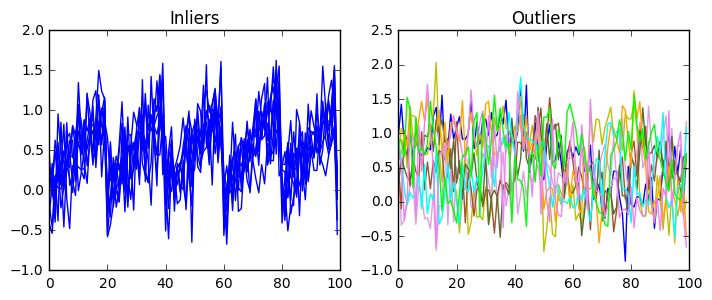

In [7]:
i_sig = 2
n_ftrs = 100
noise = 0.3
scl = 0.0
sft = 0.0

x = np.linspace(0,1,n_ftrs)

X, y = mce.synt_mix(i_sig,n_ftrs,x=x,sigma = noise,n1 = scl,n2 = sft,n3 = scl,n4 = sft)

gs = gridspec.GridSpec(1, 2)
plt.figure(figsize=(8,3)) 
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax1.set_title('Inliers')
ax2.set_title('Outliers')

inliers = X[y==i_sig]
outliers = X[y!=i_sig]
outliers_y = y[y!=i_sig]

for i in range(0,45,5):
    ax1.plot(inliers[i],'b')
    ax2.plot(outliers[i],mce.COLORS[outliers_y[i]])
    
plt.subplots_adjust(hspace=0.3,left=0.1, right=0.9, top=0.9, bottom=0.1)

## Outlier detection using autoencoders

In [8]:
# encoder\decored architecture definition
nn_en = [n_ftrs, n_ftrs//2, 2]
nn_de = [2, n_ftrs//2, n_ftrs]
network_architecture = [nn_en,nn_de]

dim_rs ={'AE':'AE','VAE':'VAE'}

for dim_r, value in dim_rs.iteritems():
    
    print '---------------  '+dim_r+'  ----------------'

    # Splitter definition
    splitter = mce.Splitter(X, value, network_architecture, clustering)

    # Splitting
    splitter.split(1,verbose=0,training_epochs=20)
    
    # outlier extraction for all of requeste metrics
    outliers = mce.outliers(X,splitter,metrics)
        
    # ensembling
    ems_outliers = mce.norm_ensemble(outliers,0.1)
    
    # AUC
    auc = roc_auc_score(y==1, ems_outliers)

    print '{}: AUC={:4.2f}'.format(dim_r,auc)

    print '...........     metric report     ...........'
    print 
    for metr in metrics:
        print metr,roc_auc_score(y==1, outliers[metr])
        
    print '*********************************************'

---------------  AE  ----------------
AE: AUC=0.98
...........     metric report     ...........

cityblock 0.986153846154
L2 0.986538461538
L4 0.986730769231
braycurtis 0.979038461538
canberra 0.910192307692
chebyshev 0.780384615385
correlation 0.987884615385
mahalanobis 0.805384615385
wL2 0.986538461538
wL4 0.986730769231
*********************************************
---------------  VAE  ----------------
VAE: AUC=0.98
...........     metric report     ...........

cityblock 0.979615384615
L2 0.98
L4 0.975384615385
braycurtis 0.910769230769
canberra 0.679423076923
chebyshev 0.866923076923
correlation 0.983269230769
mahalanobis 0.856153846154
wL2 0.979807692308
wL4 0.972884615385
*********************************************


## Outlier detection using Scikit-learn dimensionality reduction classes

In [9]:
dim_rs ={'PCA':PCA(n_components=2),
         'NMF':NMF(n_components=2), 
         'FastICA':FastICA(n_components=2, max_iter=1000)}

for dim_r, value in dim_rs.iteritems():
    
    print '---------------  '+dim_r+'  ----------------'

    # Splitter definition using Scikit-learn dimensionality reduction classes
    splitter = mce.Custom_Splitter(X, mce.sk_convert(value), clustering)

    # Splitting
    splitter.split(1,verbose=0)
    
    # outlier extraction for all of requeste metrics
    outliers = mce.outliers(X,splitter,metrics)
        
    # ensembling
    ems_outliers = mce.norm_ensemble(outliers,0.1)
    
    # AUC
    auc = roc_auc_score(y==1, ems_outliers)

    print '{}: AUC={:4.2f}'.format(dim_r,auc)

    print '...........     metric report     ...........'
    print 
    for metr in metrics:
        print metr,roc_auc_score(y==1, outliers[metr])
        
    print '*********************************************'

---------------  NMF  ----------------
NMF: AUC=0.85
...........     metric report     ...........

cityblock 0.964423076923
L2 0.968461538462
L4 0.955
braycurtis 0.656538461538
canberra 0.375
chebyshev 0.828461538462
correlation 0.969807692308
mahalanobis 0.546153846154
wL2 0.591538461538
wL4 0.461923076923
*********************************************
---------------  PCA  ----------------
PCA: AUC=0.86
...........     metric report     ...........

cityblock 0.967115384615
L2 0.970576923077
L4 0.954807692308
braycurtis 0.749423076923
canberra 0.439038461538
chebyshev 0.821923076923
correlation 0.965192307692
mahalanobis 0.546153846154
wL2 0.630384615385
wL4 0.490192307692
*********************************************
---------------  FastICA  ----------------
FastICA: AUC=0.65
...........     metric report     ...........

cityblock 0.948461538462
L2 0.955
L4 0.929038461538
braycurtis 0.5675
canberra 0.324423076923
chebyshev 0.660192307692
correlation 0.965384615385
mahalanobis 0.54